# Notebook for all simulations

In [1]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

from check_warmup import avg_warmup_count, plot_avg_warmup_count

from environment import GLMBandit

from glmbanditexp.algorithms.ecolog import EcoLog
from glmbanditexp.algorithms.gloc import Gloc
from glmbanditexp.algorithms.glm_ucb import GlmUCB
from glmbanditexp.algorithms.rs_glinucb import RS_GLinUCB
from glmbanditexp.algorithms.ofulogplus import OFULogPlus

### Warm-up Count for Rarely-Switching GLBandit

In [2]:
num_trials = 5
d=5
K=10
T=200000
kappa=50.0
R=1.0
S=5.0
lmbda=20.0
seed=186329

Running trial 1


100%|██████████| 200000/200000 [00:03<00:00, 50556.53it/s]


Running trial 2


100%|██████████| 200000/200000 [00:03<00:00, 51674.58it/s]


Running trial 3


100%|██████████| 200000/200000 [00:03<00:00, 50734.25it/s]


Running trial 4


100%|██████████| 200000/200000 [00:03<00:00, 50428.67it/s]


Running trial 5


100%|██████████| 200000/200000 [00:03<00:00, 50088.35it/s]


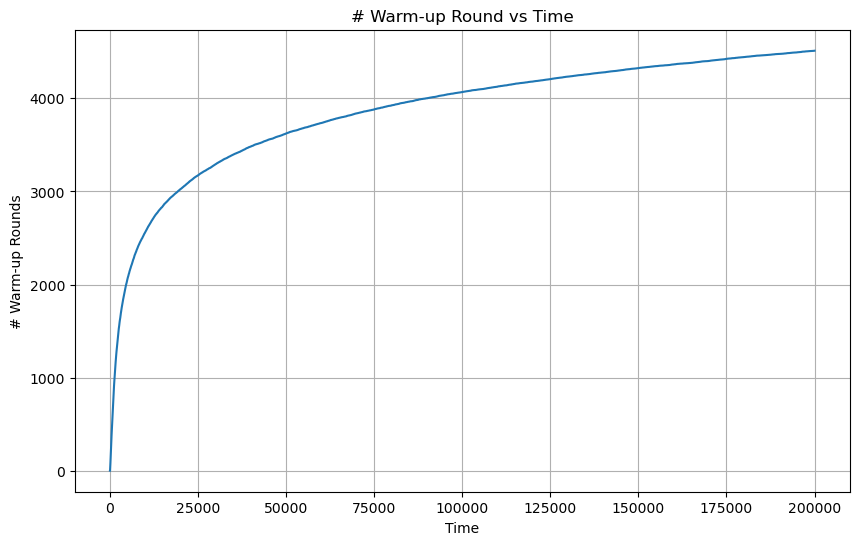

In [3]:
count = avg_warmup_count(num_trials, d, K, T, kappa, R, S, lmbda, seed)
plot_avg_warmup_count(count, show_flag=True)

## Regret Simulations

In [2]:
def simulate(num_trials, env, algo_names_list, delta):
    regret_dict = {}
    for n in range(num_trials):
        algo_arr = []
        print('Simulating trial', n+1)
        for k in algo_names_list:
            if k == 'RS-GLinUCB':
                algo = RS_GLinUCB(env.get_first_action_set(), env.kappa, env.R, env.S, env.model, env.T, delta)
            elif k == 'GLOC':
                algo = Gloc(env.get_first_action_set(), env.kappa, env.R, env.S, env.model, delta)
            elif k == 'GLM-UCB':
                algo = GlmUCB(env.get_first_action_set(), env.kappa, env.R, env.S, env.model, env.T, delta)
            elif k == 'EcoLog':
                algo = EcoLog(env.get_first_action_set(), env.kappa, env.R, env.S, env.model, delta)
            elif k == 'OfuLog+':
                algo = OFULogPlus(env.get_first_action_set(), env.kappa, env.R, env.S, env.model, env.T, delta)
            algo_arr.append(algo)
    
        for t in tqdm(range(env.T)):
            act_arr = []
            for algo in algo_arr:
                act_arr.append(algo.play_arm())
            try:
                rewards, regrets, next_arm_set = env.step(act_arr)
            except:
                print(act_arr)


            for j, algo in enumerate(algo_arr):                
                algo.update(rewards[j], regrets[j], next_arm_set)
        
        for algo in algo_arr:
            if algo.name not in regret_dict.keys():
                regret_dict[algo.name] = np.array(algo.regret_arr)
            else:
                regret_dict[algo.name] += np.array(algo.regret_arr)
        env.reset()
    
    for k in regret_dict.keys():
        regret_dict[k] /= num_trials
    
    return regret_dict


In [3]:
def plot_regret(rg_dict, T, filename):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    T_arr = np.arange(1, T+1)
    for k in rg_dict.keys():
        ax.plot(T_arr, np.cumsum(rg_dict[k]), label=k)
    ax.legend(fontsize=12)
    ax.grid()
    ax.set_xlabel('# of Rounds', fontsize=14)
    ax.set_ylabel('Cumulative Regret', fontsize=14)
    ax.set_title('Cumulative Regret vs # of Rounds', fontsize=16)
    plt.savefig(filename, dpi=600)
    plt.show()

### Logistic Model Simulation

In [4]:
config = {"full_norm": True}
config['seed'] = 109832
config['model'] = 'Logistic'
config['theta_dim'] = 5
config['num_arms'] = 20
config['theta_norm'] = 5.0
config['horizon_length'] = 20000

env = GLMBandit(config=config)
print('Kappa =', env.kappa)
print('Theta =' , env.theta)

Calculating kappa...


100%|██████████| 20000/20000 [00:00<00:00, 56548.92it/s]


Kappa = 141.6361569007383
Theta = [ 0.48016631  2.96892264  1.23390047  0.41655583 -3.77609713]


Simulating trial 1


100%|██████████| 20000/20000 [00:56<00:00, 356.37it/s]


Simulating trial 2


100%|██████████| 20000/20000 [00:56<00:00, 357.12it/s]


Simulating trial 3


100%|██████████| 20000/20000 [00:56<00:00, 355.95it/s]


Simulating trial 4


100%|██████████| 20000/20000 [00:56<00:00, 356.33it/s]


Simulating trial 5


100%|██████████| 20000/20000 [00:56<00:00, 355.81it/s]


Simulating trial 6


100%|██████████| 20000/20000 [00:55<00:00, 358.30it/s]


Simulating trial 7


100%|██████████| 20000/20000 [00:56<00:00, 356.75it/s]


Simulating trial 8


100%|██████████| 20000/20000 [00:55<00:00, 357.15it/s]


Simulating trial 9


100%|██████████| 20000/20000 [00:55<00:00, 357.16it/s]


Simulating trial 10


100%|██████████| 20000/20000 [00:55<00:00, 357.86it/s]


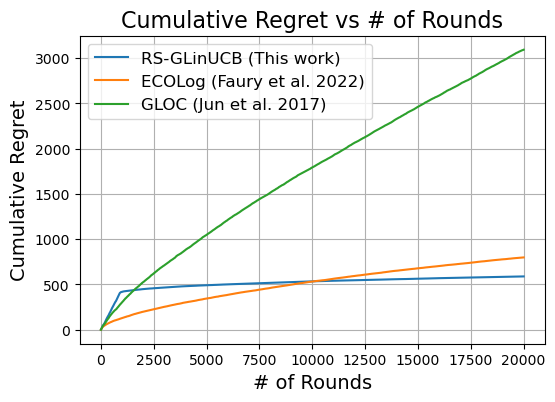

In [6]:
algo_names_list = ['RS-GLinUCB', 'EcoLog', 'GLOC']
num_trials = 10

regret_dict = simulate(num_trials, env, algo_names_list, 0.01)
with open('./Results/experiment_logistic.pickle', 'wb') as f:
    pickle.dump(regret_dict, f)
plot_regret(regret_dict, env.T, './Results/Probit_Regret.png')

### Probit Model Simulation

In [16]:
config = {}
config['seed'] = 109832
config['model'] = 'Probit'
config['theta_dim'] = 5
config['num_arms'] = 20
config['theta_norm'] = 3.0
config['horizon_length'] = 5000
config['full_norm'] = True

env = GLMBandit(config=config)
print('Kappa =', env.kappa)
print('Theta =' , env.theta)

Calculating kappa...


100%|██████████| 5000/5000 [00:00<00:00, 75532.49it/s]


Kappa = 193.18410051249518
Theta = [ 0.28809979  1.78135359  0.74034028  0.2499335  -2.26565828]


Simulating trial 1


100%|██████████| 5000/5000 [02:56<00:00, 28.32it/s]


Simulating trial 2


100%|██████████| 5000/5000 [02:54<00:00, 28.64it/s]


Simulating trial 3


100%|██████████| 5000/5000 [02:52<00:00, 29.05it/s]


Simulating trial 4


100%|██████████| 5000/5000 [02:52<00:00, 29.02it/s]


Simulating trial 5


100%|██████████| 5000/5000 [02:53<00:00, 28.76it/s]


Simulating trial 6


100%|██████████| 5000/5000 [02:52<00:00, 28.97it/s]


Simulating trial 7


100%|██████████| 5000/5000 [02:52<00:00, 29.03it/s]


Simulating trial 8


100%|██████████| 5000/5000 [02:53<00:00, 28.77it/s]


Simulating trial 9


100%|██████████| 5000/5000 [02:58<00:00, 27.97it/s]


Simulating trial 10


100%|██████████| 5000/5000 [02:53<00:00, 28.87it/s]


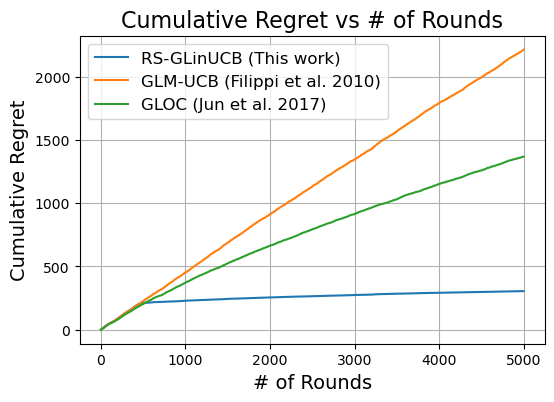

In [17]:
algo_names_list = ['RS-GLinUCB', 'GLM-UCB', 'GLOC']
num_trials = 10

regret_dict = simulate(num_trials, env, algo_names_list, 0.01)
with open('./Results/experiment_probit.pickle', 'wb') as f:
    pickle.dump(regret_dict, f)
plot_regret(regret_dict, env.T, './Results/Probit_Regret.png')

## Time Comparison

In [5]:
import time

In [6]:
def single_algo_multiple_runs(env, algo_name, num_trials):
    delta = 0.01
    dur_arr = []
    for _ in range(num_trials):
        if algo_name == 'RS-GLinUCB':
            algo = RS_GLinUCB(env.get_first_action_set(), env.kappa, env.R, env.S, env.model, env.T, delta)
        elif algo_name == 'GLOC':
            algo = Gloc(env.get_first_action_set(), env.kappa, env.R, env.S, env.model, delta)
        elif algo_name == 'GLM-UCB':
            algo = GlmUCB(env.get_first_action_set(), env.kappa, env.R, env.S, env.model, env.T, delta)
        elif algo_name == 'EcoLog':
            algo = EcoLog(env.get_first_action_set(), env.kappa, env.R, env.S, env.model, delta)
        elif algo_name == 'OfuLog+':
            algo = OFULogPlus(env.get_first_action_set(), env.kappa, env.R, env.S, env.model, env.T, delta)
        
        start = time.monotonic_ns()
        for _ in range(env.T):
            a = algo.play_arm()
            r, reg, arms = env.step([a])
            algo.update(r[0], reg[0], arms)
        end = time.monotonic_ns()
        env.reset()
        dur_arr.append((end - start) / 1000000000.0)
    
    avg_dur = np.mean(dur_arr)
    std_dur = np.std(dur_arr)
    return algo.name, avg_dur, std_dur

### Logistic Model

In [14]:
algo_names = ['RS-GLinUCB', 'EcoLog']
config = {}
config['seed'] = 109832
config['model'] = 'Logistic'
config['theta_dim'] = 5
config['num_arms'] = 20
config['theta_norm'] = 2.0
config['horizon_length'] = 20000
config['full_norm'] = True

env_low = GLMBandit(config=config)
print('Kappa =', env_low.kappa)

Calculating kappa...


100%|██████████| 20000/20000 [00:00<00:00, 59085.11it/s]


Kappa = 9.349591517256105


In [15]:
algo_names = ['RS-GLinUCB', 'EcoLog']
config = {}
config['seed'] = 109832
config['model'] = 'Logistic'
config['theta_dim'] = 5
config['num_arms'] = 20
config['theta_norm'] = 5.0
config['horizon_length'] = 20000
config['full_norm'] = True

env_high = GLMBandit(config=config)
print('Kappa =', env_high.kappa)

Calculating kappa...


100%|██████████| 20000/20000 [00:00<00:00, 61438.04it/s]


Kappa = 141.6361569007383


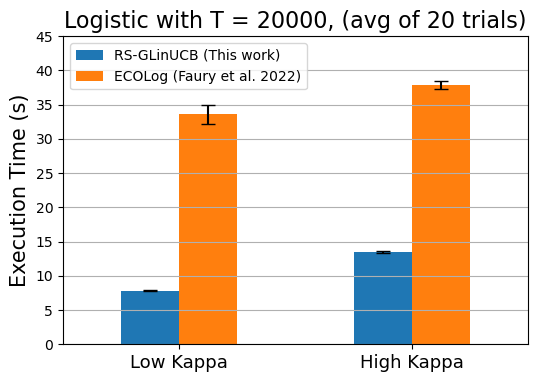

In [24]:
env_list = [env_low, env_high]
num_trials = 20
T = env_list[0].T
algo_dict_mean = {}
algo_dict_std = {}

for env in env_list:
    for k in algo_names:
        name, avg_time, std_time = single_algo_multiple_runs(env, k, num_trials)
        if name not in algo_dict_mean.keys():
            algo_dict_mean[name], algo_dict_std[name] = [avg_time], [std_time]
        else:
            algo_dict_mean[name].append(avg_time)
            algo_dict_std[name].append(std_time)
        time.sleep(10)

df_mean = pd.DataFrame(algo_dict_mean, index=['Low Kappa', 'High Kappa'])
df_std = pd.DataFrame(algo_dict_std, index=['Low Kappa', 'High Kappa'])

# labels = {'ECOLog (Faury et al. 2022)' : 'ECOLog\n(Faury et al. 2022)', 'RS-GLinUCB (This work)' : 'RS-GLinUCB\n(This work)'}
_, ax = plt.subplots(1, 1, figsize=(6, 4))
df_mean.plot(kind='bar', ax=ax, yerr=df_std, rot=0, capsize=5)
# ax.bar([labels[a] for a in list(algo_dict.keys())], [algo_dict[k][0] for k in algo_dict.keys()], yerr=[algo_dict[k][1] for k in algo_dict.keys()], color = ['blue', 'orange'], ecolor='black', capsize=15)
ax.set_ylabel('Execution Time (s)', fontsize=15)
ax.tick_params(axis='x', labelsize=13)
ax.grid(axis='y')
ax.set_ylim(top=45)
ax.set_title(f'Logistic with T = {T}, (avg of {num_trials} trials)', fontsize=16)
plt.savefig('./Results/Time_Logistic.png', dpi=600)
plt.show()

In [19]:
df_mean.to_csv('./Results/Logistic_Time_kappa_mean.csv')
df_std.to_csv('./Results/Logistic_Time_kappa_std.csv')

### Probit Model

In [11]:
algo_names = ['RS-GLinUCB', 'GLOC']
config = {}
config['seed'] = 109832
config['model'] = 'Probit'
config['theta_dim'] = 5
config['num_arms'] = 20
config['theta_norm'] = 2.0
config['horizon_length'] = 5000
config['full_norm'] = True

env_low = GLMBandit(config=config)
print('Low Kappa =', env_low.kappa)

config = {}
config['seed'] = 109832
config['model'] = 'Probit'
config['theta_dim'] = 5
config['num_arms'] = 20
config['theta_norm'] = 3.0
config['horizon_length'] = 5000
config['full_norm'] = True

env_high = GLMBandit(config=config)
print('High Kappa =', env_high.kappa)

Calculating kappa...


100%|██████████| 5000/5000 [00:00<00:00, 70246.46it/s]


Low Kappa = 17.286374206924833
Calculating kappa...


100%|██████████| 5000/5000 [00:00<00:00, 75362.57it/s]


High Kappa = 193.18410051249518


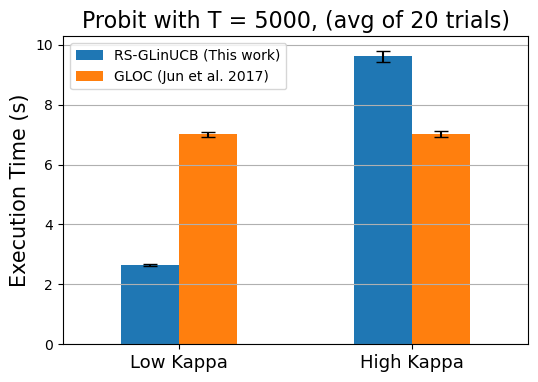

In [12]:
env_list = [env_low, env_high]
num_trials = 20
T = env_list[0].T
algo_dict_mean = {}
algo_dict_std = {}

for env in env_list:
    for k in algo_names:
        name, avg_time, std_time = single_algo_multiple_runs(env, k, num_trials)
        if name not in algo_dict_mean.keys():
            algo_dict_mean[name], algo_dict_std[name] = [avg_time], [std_time]
        else:
            algo_dict_mean[name].append(avg_time)
            algo_dict_std[name].append(std_time)
        time.sleep(10)

df_mean_probit = pd.DataFrame(algo_dict_mean, index=['Low Kappa', 'High Kappa'])
df_std_probit = pd.DataFrame(algo_dict_std, index=['Low Kappa', 'High Kappa'])

# labels = {'ECOLog (Faury et al. 2022)' : 'ECOLog\n(Faury et al. 2022)', 'RS-GLinUCB (This work)' : 'RS-GLinUCB\n(This work)'}
_, ax = plt.subplots(1, 1, figsize=(6, 4))
df_mean_probit.plot(kind='bar', ax=ax, yerr=df_std_probit, rot=0, capsize=5)
# ax.bar([labels[a] for a in list(algo_dict.keys())], [algo_dict[k][0] for k in algo_dict.keys()], yerr=[algo_dict[k][1] for k in algo_dict.keys()], color = ['blue', 'orange'], ecolor='black', capsize=15)
ax.set_ylabel('Execution Time (s)', fontsize=15)
ax.tick_params(axis='x', labelsize=13)
ax.grid(axis='y')
# ax.set_ylim(top=45)
ax.set_title(f'Probit with T = {T}, (avg of {num_trials} trials)', fontsize=16)
plt.savefig('./Results/Time_Probit.png', dpi=600)
plt.show()

In [13]:
df_mean_probit.to_csv('./Results/Probit_Time_kappa_mean.csv')
df_std_probit.to_csv('./Results/Probit_Time_kappa_std.csv')